# Visualize the ADCP data

### Load the packages

In [12]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime 
import cmocean
import pandas as pd
# Uncomment to have interactive figures:
%matplotlib widget 

### Parameters

Specify the path to the data files and the list of filenames to read:

In [13]:
data_path="../data"
level="Level2"
ADCP="RDI300"
# filepath=os.path.join(data_path,level,ADCP)
filepath="C:/Users/tdoda/Level2/test/RDI300"

# filenames=["L2_20240702_085011.nc","L2_20240723_133746.nc"] # Specific files as a list
filenames=os.listdir(filepath) # All files
gap_period=3600 # temporal gap above which a new period is considered [s]

Smoothing options:

In [14]:
smoothing=False # If True, velocity data is smoothened on the plot, both temporally and vertically
temp_window=5 # Length of the time averaging window for smoothing
depth_window=5 # Length of the depth averaging window for smoothing

Figure saving option:

In [15]:
savefig=False # If True, all figures are exported as png

Plot parameters:

In [16]:
dt=30 # Time step of the x axis [days], data is sampled every dt/10 to plot it faster
title_size=10 # Font size of the title
start_date=''# Starting date specified as datetime(yyyy,mm,dd) or '' to use the first measurement
end_date='' # End date specified as datetime(yyyy,mm,dd) or '' to use the last measurement

### Open the data files

In [17]:
fullpaths = [os.path.join(filepath, f) for f in filenames]

# Concatenate all the files while opening them, along the dimension "time" and making an union of the dimension "depth" since the depth values might change between periods
D = xr.open_mfdataset(fullpaths, combine='nested', concat_dim='time', join='outer')
# Set the variables to NaN just after a big temporal gap in the data:
tnumval=D.time.values.astype("datetime64[s]").astype(np.int64)
ind_gaps=np.where(np.diff(tnumval)>=gap_period)[0]+1
for v in D.data_vars:
    if "time" in D[v].dims:
        if len(D[v].dims)==2:
            D[v].values[:,ind_gaps]=np.full((len(D.depth.values),len(ind_gaps)),np.nan)
        else:
            D[v].values[ind_gaps]=np.full(len(ind_gaps),np.nan)

# Make the time dimension continuous:
dt_pd = (pd.to_datetime(D.time[1].values) - pd.to_datetime(D.time[0].values)).total_seconds()  # in seconds
time_uniform = pd.date_range(start=pd.to_datetime(D.time.min().values), end=pd.to_datetime(D.time.max().values), freq=f'{int(dt_pd)}s')  
D = D.interp(time=time_uniform) # Interpolation to the constant grid

C:\Users\tdoda\AppData\Local\anaconda3\envs\datalakes\Lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [18]:
dateval=D.time.values.astype("datetime64[s]").astype(datetime)
tnumval=D.time.values.astype("datetime64[s]").astype(np.int64)
depthval=D.depth.values

### Figure 1 - Data quality (correlation, echo, percentages good)

Select specified period and temporal step:

In [19]:
dval=int(dt*86400/(tnumval[1]-tnumval[0])/10) # Temporal index step

# Set starting date:
if start_date:
    if start_date<dateval[-1]:
        ind_start=np.where(dateval>=start_date)[0][0]
    else:
        ind_start=0
        print("WARNING: starting time is after last measurement, use first measurement instead")
else:
    ind_start=0

# Set end date:
if end_date:
    if end_date>dateval[0]:
        ind_end=np.where(dateval<=end_date)[0][-1]
    else:
        ind_end=len(dateval)
        print("WARNING: ending time is before the first measurement, use last measurement instead")   
else:
    ind_end=len(dateval)
    
Dperiod=D.isel(time=np.arange(ind_start,ind_end)) 
dateval_period=dateval[ind_start:ind_end]

Get min/max values for colormaps:

In [20]:
minecho=np.nanmin(np.array([Dperiod.echo1.values,Dperiod.echo2.values,Dperiod.echo3.values,Dperiod.echo4.values]))
maxecho=np.nanmax(np.array([Dperiod.echo1.values,Dperiod.echo2.values,Dperiod.echo3.values,Dperiod.echo4.values]))
mincorr=np.nanmin(np.array([Dperiod.corr1.values,Dperiod.corr2.values,Dperiod.corr3.values,Dperiod.corr4.values]))
maxcorr=np.nanmax(np.array([Dperiod.corr1.values,Dperiod.corr2.values,Dperiod.corr3.values,Dperiod.corr4.values]))
minPG=np.nanmin(np.array([Dperiod.prcnt_gd1.values,Dperiod.prcnt_gd2.values,Dperiod.prcnt_gd3.values,Dperiod.prcnt_gd4.values]))
maxPG=np.nanmax(np.array([Dperiod.prcnt_gd1.values,Dperiod.prcnt_gd2.values,Dperiod.prcnt_gd3.values,Dperiod.prcnt_gd4.values]))

Depth-interpolation to remove white lines in the colormap:

In [21]:
Dinterp=Dperiod.copy()
for var_name in Dinterp.data_vars:
    data_interp=Dinterp[var_name].values
    if len(data_interp.shape)>1: # 2D
        for kt in range(len(dateval_period)):
            bool_nan=np.isnan(data_interp[:,kt])
            if np.sum(bool_nan)>0 and np.sum(bool_nan)<len(bool_nan):
                data_interp[:,kt]=np.interp(depthval, depthval[~bool_nan], data_interp[~bool_nan,kt], left=np.nan, right=np.nan)
        Dinterp[var_name]=xr.DataArray(data_interp, coords=Dinterp[var_name].coords, dims=Dinterp[var_name].dims)

Plot the quality data:

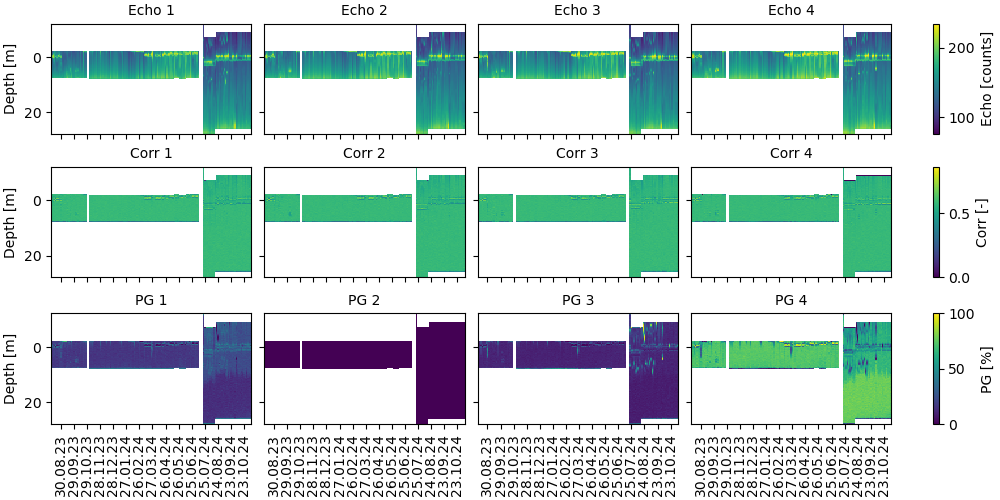

In [26]:
fig,ax=plt.subplots(3,4,figsize=(10,5),sharex=True,sharey=True,layout="constrained")

# Subpanels row 1 - Echo
ax[0,0].pcolormesh(dateval_period[::dval],depthval,Dinterp.echo1.values[:,::dval],vmin=minecho,vmax=maxecho)
ax[0,0].set_title("Echo 1",fontsize=title_size)
ax[0,0].set_ylabel("Depth [m]")
ax[0,1].pcolormesh(dateval_period[::dval],depthval,Dinterp.echo2.values[:,::dval],vmin=minecho,vmax=maxecho)
ax[0,1].set_title("Echo 2",fontsize=title_size)
ax[0,2].pcolormesh(dateval_period[::dval],depthval,Dinterp.echo3.values[:,::dval],vmin=minecho,vmax=maxecho)
ax[0,2].set_title("Echo 3",fontsize=title_size)
pecho4=ax[0,3].pcolormesh(dateval_period[::dval],depthval,Dinterp.echo4.values[:,::dval],vmin=minecho,vmax=maxecho)
ax[0,3].set_title("Echo 4",fontsize=title_size)
cb1=fig.colorbar(pecho4, ax=ax[0, :], location='right')
cb1.set_label("Echo [counts]",rotation=90)

# Subpanels row 2 - Correlations
ax[1,0].pcolormesh(dateval_period[::dval],depthval,Dinterp.corr1.values[:,::dval],vmin=mincorr,vmax=maxcorr)
ax[1,0].set_title("Corr 1",fontsize=title_size)
ax[1,0].set_ylabel("Depth [m]")
ax[1,1].pcolormesh(dateval_period[::dval],depthval,Dinterp.corr2.values[:,::dval],vmin=mincorr,vmax=maxcorr)
ax[1,1].set_title("Corr 2",fontsize=title_size)
ax[1,2].pcolormesh(dateval_period[::dval],depthval,Dinterp.corr3.values[:,::dval],vmin=mincorr,vmax=maxcorr)
ax[1,2].set_title("Corr 3",fontsize=title_size)
pcorr4=ax[1,3].pcolormesh(dateval_period[::dval],depthval,Dinterp.corr4.values[:,::dval],vmin=mincorr,vmax=maxcorr)
ax[1,3].set_title("Corr 4",fontsize=title_size)
cb2=fig.colorbar(pcorr4, ax=ax[1, :], location='right')
cb2.set_label("Corr [-]",rotation=90)

# Subpanels row 3 - Percentages Good
ax[2,0].pcolormesh(dateval_period[::dval],depthval,Dinterp.prcnt_gd1.values[:,::dval],vmin=minPG,vmax=maxPG)
ax[2,0].set_title("PG 1",fontsize=title_size)
ax[2,0].set_ylabel("Depth [m]")
ax[2,1].pcolormesh(dateval_period[::dval],depthval,Dinterp.prcnt_gd2.values[:,::dval],vmin=minPG,vmax=maxPG)
ax[2,1].set_title("PG 2",fontsize=title_size)
ax[2,2].pcolormesh(dateval_period[::dval],depthval,Dinterp.prcnt_gd3.values[:,::dval],vmin=minPG,vmax=maxPG)
ax[2,2].set_title("PG 3",fontsize=title_size)
pPG4=ax[2,3].pcolormesh(dateval_period[::dval],depthval,Dinterp.prcnt_gd4.values[:,::dval],vmin=minPG,vmax=maxPG)
ax[2,3].set_title("PG 4",fontsize=title_size)
cb3=fig.colorbar(pPG4, ax=ax[2, :], location='right')
cb3.set_label("PG [%]",rotation=90)

ax[0,0].invert_yaxis()
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
ax[0,0].xaxis.set_major_locator(mdates.DayLocator(interval=dt))
ax[2,0].tick_params(axis='x', labelrotation=90)
ax[2,1].tick_params(axis='x', labelrotation=90)
ax[2,2].tick_params(axis='x', labelrotation=90)
ax[2,3].tick_params(axis='x', labelrotation=90)

In [27]:
# Save fig
if savefig:
    fig.savefig(ADCP+"_"+level+"_"+dateval_period[0].strftime("%Y%m%d")+"_"+dateval_period[-1].strftime("%Y%m%d")+"_data_quality.png",dpi=400)

### Figure 2 - Flag indices

Get the flag of each test in a separate array:

In [28]:
n_test=9 # Number of quality control tests (including envass basic check)
name_tests=["envass", "interface", "corrmag", "PG14", "PG3", "velerror", "tilt", "corrstd", "echodiff"]

depth_interp = np.arange(Dperiod.depth.min().item(), Dperiod.depth.max().item(), 0.1)

# Interpolate indices along a regular depth to better visualize the values
depth_regular=np.arange(Dperiod.depth.min().item(), Dperiod.depth.max().item(), 1)
uqual_noNaN=Dperiod.u_qual.ffill(dim='depth').bfill(dim='depth')
uqual_noNaN = uqual_noNaN.interp(depth=depth_regular)

flag_index=np.arange(0,n_test,1) 
flag_index_matrix=np.zeros((uqual_noNaN.values.shape[0],uqual_noNaN.values.shape[1],len(flag_index))) # One (depth*time) array for each test
flagval=np.copy(uqual_noNaN.values) # Flag values (base 2)
for kflag in np.arange(flag_index[-1],flag_index[0]-1,-1):
    flagval_new=flagval-2**kflag
    flag_index_matrix[:,:,kflag]=(flagval_new>=0) # Array for specific test with 1 if the data didn't pass the test
    flagval[flagval_new>=0]=flagval_new[flagval_new>=0]
noflag=uqual_noNaN.values==0

Plot the flag value (0,1) of each test:

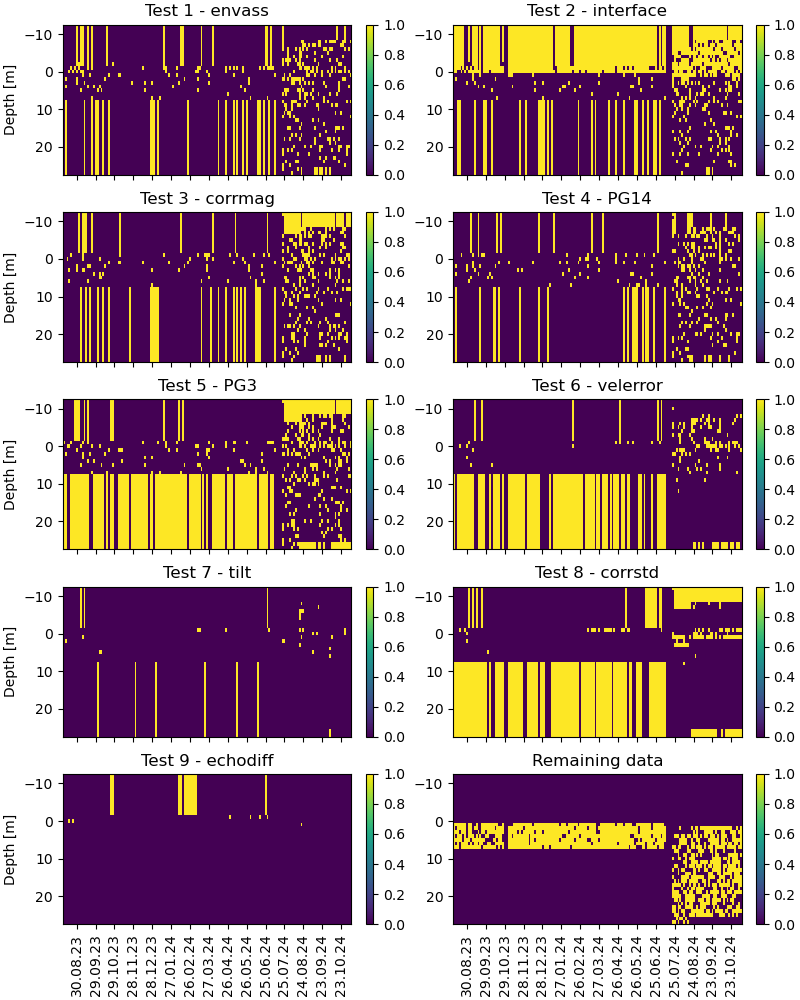

In [29]:
nrow=int(np.ceil((len(flag_index)+1)/2))
fig,ax=plt.subplots(nrow,2,figsize=(8,10),sharex=True,sharey=False,layout="constrained")

for kval in range(len(flag_index)+1):
    if kval%2==0:
        icol=0
    else:
        icol=1
    irow=int(np.floor(kval/2))
    if kval<len(flag_index):
        pindex=ax[irow,icol].pcolormesh(dateval_period[::dval],depth_regular,flag_index_matrix[:,::dval,kval],vmin=0,vmax=1)
    else:
        pindex=ax[irow,icol].pcolormesh(dateval_period[::dval],depth_regular,noflag[:,::dval],vmin=0,vmax=1)
    cb1=fig.colorbar(pindex,location="right")
    ax[irow,icol].xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
    ax[irow,icol].xaxis.set_major_locator(mdates.DayLocator(interval=dt))
    if icol==0:
        ax[irow,icol].set_ylabel("Depth [m]")
    if kval<len(flag_index):  
        ax[irow,icol].set_title("Test {} - {}".format(kval+1,name_tests[kval]))
    else:
        ax[irow,icol].set_title("Remaining data")
    ax[irow,icol].invert_yaxis()
    ax[irow,icol].tick_params(axis='x', labelrotation=90)


In [30]:
# Save figure
if savefig:
    fig.savefig(ADCP+"_"+level+"_"+dateval_period[0].strftime("%Y%m%d")+"_"+dateval_period[-1].strftime("%Y%m%d")+"_flag_indices.png",dpi=400)

Plot the velocity data: 

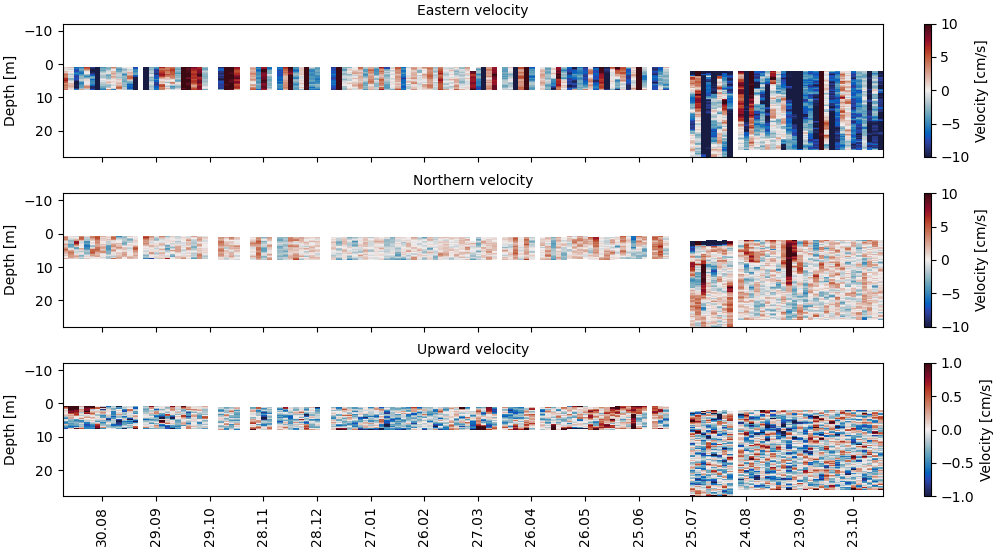

In [31]:
fig,ax=plt.subplots(3,1,figsize=(10,5.5),sharex=True,sharey=True,layout="constrained")
horvel_lim=[-10,10]
vertvel_lim=[-1,1]
Uval=Dinterp.u.values*100
if smoothing:
    Usmooth=pd.DataFrame(Uval).T.rolling(window=temp_window).mean().T # Temporal smoothing across columns
    Usmooth=Usmooth.rolling(window=depth_window).mean().values # Depth smoothing across rows
else:
    Usmooth=Uval
pVE=ax[0].pcolormesh(dateval_period[::dval],depthval,Usmooth[:,::dval],vmin=horvel_lim[0],vmax=horvel_lim[1],cmap=cmocean.cm.balance)
ax[0].set_title("Eastern velocity",fontsize=title_size)
ax[0].set_ylabel("Depth [m]")
cb1=fig.colorbar(pVE,location="right")
cb1.set_label("Velocity [cm/s]",rotation=90)

Vval=Dinterp.v.values*100
if smoothing:
    Vsmooth=pd.DataFrame(Vval).T.rolling(window=temp_window).mean().T
    Vsmooth=Vsmooth.rolling(window=depth_window).mean().values
else:
    Vsmooth=Vval
pVN=ax[1].pcolormesh(dateval_period[::dval],depthval,Vsmooth[:,::dval],vmin=horvel_lim[0],vmax=horvel_lim[1],cmap=cmocean.cm.balance)
ax[1].set_title("Northern velocity",fontsize=title_size)
ax[1].set_ylabel("Depth [m]")
cb2=fig.colorbar(pVN,location="right")
cb2.set_label("Velocity [cm/s]",rotation=90)

Wval=Dinterp.w.values*100
if smoothing:
    Wsmooth=pd.DataFrame(Wval).T.rolling(window=temp_window).mean().T
    Wsmooth=Wsmooth.rolling(window=depth_window).mean().values
else:
    Wsmooth=Wval
pVU=ax[2].pcolormesh(dateval_period[::dval],depthval,Wsmooth[:,::dval],vmin=vertvel_lim[0],vmax=vertvel_lim[1],cmap=cmocean.cm.balance)
ax[2].set_title("Upward velocity",fontsize=title_size)
ax[2].set_ylabel("Depth [m]")
cb3=fig.colorbar(pVU,location="right")
cb3.set_label("Velocity [cm/s]",rotation=90)

ax[0].invert_yaxis()
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=dt))
ax[2].tick_params(axis='x', labelrotation=90)

In [17]:
# Save figure
if savefig:
    fig.savefig(ADCP+"_"+level+"_"+dateval_period[0].strftime("%Y%m%d")+"_"+dateval_period[-1].strftime("%Y%m%d")+"_velocities.png",dpi=400)